In [2]:
import numpy as np
import pandas as pd
import cudf
import os
import time

In [3]:
from timeit import default_timer

class Timer(object):
    def __init__(self):
        self._timer = default_timer
    
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        """Start the timer."""
        self.start = self._timer()

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        self.interval = self.end - self.start

In [4]:
import gzip
def load_data(nrows, ncols, cached = 'data/mortgage.npy.gz'):
    X = np.random.rand(nrows,ncols)
    df = pd.DataFrame({'fea%d'%i:X[:,i].astype(np.float32) for i in range(X.shape[1])})
    return df

In [5]:
bench_dims = [64, 128, 256, 512]

In [30]:
import pickle

def perform_bench(func, name, rerun = False, n_runs = 3, out_filename = "benchmark.pickle", 
                  bench_rows = [2**x for x in range(10, 16)], bench_dims = bench_dims):
    
    if os.path.exists(out_filename):
        print("Opened benchmark results from %s" % (out_filename))
        with open(out_filename, 'rb') as f:
            final_results = pickle.load(f)
    else:
        final_results = {}
        
    if name in final_results:
        results = final_results[name]
    else:
        results = {}
        final_results[name] = results
        
    for n_rows in bench_rows:
        for n_dims in bench_dims:
            if (n_rows, n_dims) not in results or rerun:
                
                print("Running %s. (nrows=%d, n_dims=%d)" % (name, n_rows, n_dims))
                speedup = [func(n_rows, n_dims) for i in range(n_runs)]
                results[(n_rows, n_dims)] = np.mean(speedup)
                print("Speedup for %s = %f" % (str((n_rows, n_dims)), results[(n_rows, n_dims)]))
                
                with open(out_filename, 'wb') as f:
                    pickle.dump(final_results, f, pickle.HIGHEST_PROTOCOL)
            
            
    

In [26]:
import numpy as np
import pandas as pd
import cudf
import numba
from librmm_cffi import librmm as rmm
from numba.cuda.cudadrv.driver import driver
import math
from numba import cuda

def row_matrix(df):
    # matrix = rmm.device_array(shape=(nrow, ncol), dtype=dtype, order='C')
    # for colidx, col in enumerate(cols):
    #     gpu_row_matrix.forall(matrix[:, colidx].size)(matrix[:, colidx],
    #                                                   col.to_gpu_array(),
    #                                                   nrow, ncol)
    """Compute the C (row major) version gpu matrix of df

    This implements the algorithm documented in
    http://devblogs.nvidia.com/parallelforall/efficient-matrix-transpose-cuda-cc/

    :param a: an `np.ndarray` or a `DeviceNDArrayBase` subclass. If already on
        the device its stream will be used to perform the transpose (and to copy
        `b` to the device if necessary).

    Adapted from numba:
    https://github.com/numba/numba/blob/master/numba/cuda/kernels/transpose.py
    """

    print("STARTING")

    cols = [df._cols[k] for k in df._cols]
    ncol = len(cols)
    nrow = len(df)
    dtype = cols[0].dtype

    a = df.as_gpu_matrix(order='F')
    b = rmm.device_array((nrow, ncol), dtype=dtype, order='C')
    dtype = numba.typeof(a)

    tpb = driver.get_device().MAX_THREADS_PER_BLOCK

    tile_width = int(math.pow(2, math.log(tpb, 2) / 2))
    tile_height = int(tpb / tile_width)

    tile_shape = (tile_height, tile_width + 1)

    @cuda.jit
    def kernel(input, output):

        tile = cuda.shared.array(shape=tile_shape, dtype=numba.float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bx = cuda.blockIdx.x * cuda.blockDim.x
        by = cuda.blockIdx.y * cuda.blockDim.y
        y = by + tx
        x = bx + ty

        if by + ty < input.shape[0] and bx + tx < input.shape[1]:
            tile[ty, tx] = input[by + ty, bx + tx]
        cuda.syncthreads()
        if y < output.shape[0] and x < output.shape[1]:
            output[y, x] = tile[tx, ty]

    # one block per tile, plus one for remainders
    blocks = int(b.shape[1] / tile_height + 1), int(b.shape[0] / tile_width + 1)
    # one thread per tile element
    threads = tile_height, tile_width
    kernel[blocks, threads](a, b)

    return b


In [7]:
from sklearn.neighbors import KDTree as skKNN
from cuml import KNN as cumlKNN

def bench_knn(rows, dims):
    
    X = load_data(rows,int(dims / 2))
    n_neighbors = dims
    sk_start = time.time()
    knn_sk = skKNN(X)
    D_sk,I_sk = knn_sk.query(X,n_neighbors)
    sk_elapsed = time.time() - float(sk_start)

    X = cudf.DataFrame.from_pandas(X)
    cu_start = time.time()
    knn_cuml = cumlKNN(n_gpus=1)
    knn_cuml.fit(X)
    D_cuml,I_cuml = knn_cuml.query(X,n_neighbors)
    cu_elapsed = time.time() - cu_start
    return sk_elapsed / float(cu_elapsed)

In [8]:
%%time
knn_results = perform_bench(bench_knn, "knn")

Opened benchmark results from benchmark.pickle
Running knn. (nrows=1024, n_dims=64)
Speedup for (1024, 64) = 0
Running knn. (nrows=1024, n_dims=128)
Speedup for (1024, 128) = 0
Running knn. (nrows=1024, n_dims=256)


KeyboardInterrupt: 

In [31]:
from sklearn.cluster import DBSCAN as skDBSCAN
from cuml import DBSCAN as cumlDBSCAN

def bench_dbscan(rows, dims):
    
    eps = 3
    min_samples = 2

    X = load_data(rows,dims)
    sk_start = time.time()
    clustering_sk = skDBSCAN(eps = eps, min_samples = min_samples, algorithm = "brute")
    clustering_sk.fit(X)
    sk_elapsed = time.time() - sk_start
    

    X = cudf.DataFrame.from_pandas(X)
    print("CUML")
    cu_start = time.time()
    clustering_cuml = cumlDBSCAN(eps = eps, min_samples = min_samples)
    clustering_cuml.fit(X, row_matrix)
    cu_elapsed = time.time() - cu_start
    print("END_CUML")
    
    return sk_elapsed / cu_elapsed

In [ ]:
dbscan_results = perform_bench(bench_dbscan, "dbscan", rerun = True)

In [98]:
from sklearn.linear_model import LinearRegression as skLR
from cuml import LinearRegression as cumlLR

def bench_linear_regression(rows, dims, gpu_only):
    
    X = load_data(rows, dims)
    y = load_data(rows, 1)["fea0"]

    if not gpu_only:
        sk_start = time.time()
        print("SK")
        clustering_sk = skLR()
        clustering_sk.fit(X, y)
        sk_elapsed = time.time() - sk_start
    
    X = cudf.DataFrame.from_pandas(X)
    y = cudf.Series.from_pandas(y)
    
    print("CUML")
    cu_start = time.time()
    cuml_lr = cumlLR()
    cuml_lr.fit(X, y)
    cu_elapsed = time.time() - cu_start
    
    return sk_elapsed / cu_elapsed
    

In [ ]:
lr_results = perform_bench(bench_linear_regression, "linear_regression")

In [23]:
from sklearn.decomposition import PCA as skPCA
from cuml import PCA as cumlPCA

def bench_pca(rows, dims, gpu_only):
    X = load_data(rows, dims)
    
    if not gpu_only:
        sk_start = time.time()
        print("SK")
        skpca = skPCA(n_components = 10)
        skpca.fit(X)
        sk_elapsed = time.time() - sk_start
    
    print("SK: " + str(sk_elapsed))
    
    X = cudf.DataFrame.from_pandas(X)
    
    print("CUML")
    cu_start = time.time()
    cumlpca = cumlPCA(n_components = 10)
    cumlpca.fit(X)
    cu_elapsed = time.time() - cu_start
    
    print("CUML: " + str(cu_elapsed))
    
    return sk_elapsed / cu_elapsed


In [ ]:
pca_results = perform_bench(bench_pca, "pca", rerun = True)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 25, 12.5
rcParams['figure.dpi'] = 200

sns.set_style("darkgrid")


def chart_results(results, title = "Speedup: cuML vs SKLearn", dims = bench_dims):
    final = {}
    
    plts = []
    for dim in dims:
        data = {k: v for (k, v) in results.items() if dim == k[1]}
        
        if len(data) > 0:
            data = [(k[0], v) for k, v in data.items()]
            data.sort(key = lambda x: x[0])

            final[dim] = list(map(lambda x: x[1], data))

            keys = list(map(lambda x: np.log2(x[0]), data))
        line = plt.plot(keys, final[dim], label = str(dim), linewidth = 3,  marker = 'o', markersize = 7)
        
        plts.append(line[0])
    leg = plt.legend(handles = plts, fontsize = 15)
    leg.set_title("Dimensions", prop = {'size':'x-large'})    
    plt.title(title, fontsize = 50)
    
    plt.ylabel("Speedup", fontsize = 30)
    plt.xlabel("Training Examples (2^x)", fontsize = 30)
    
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    plt.show()

In [34]:
with open("benchmark.pickle", 'rb') as f:
    final_results = pickle.load(f)

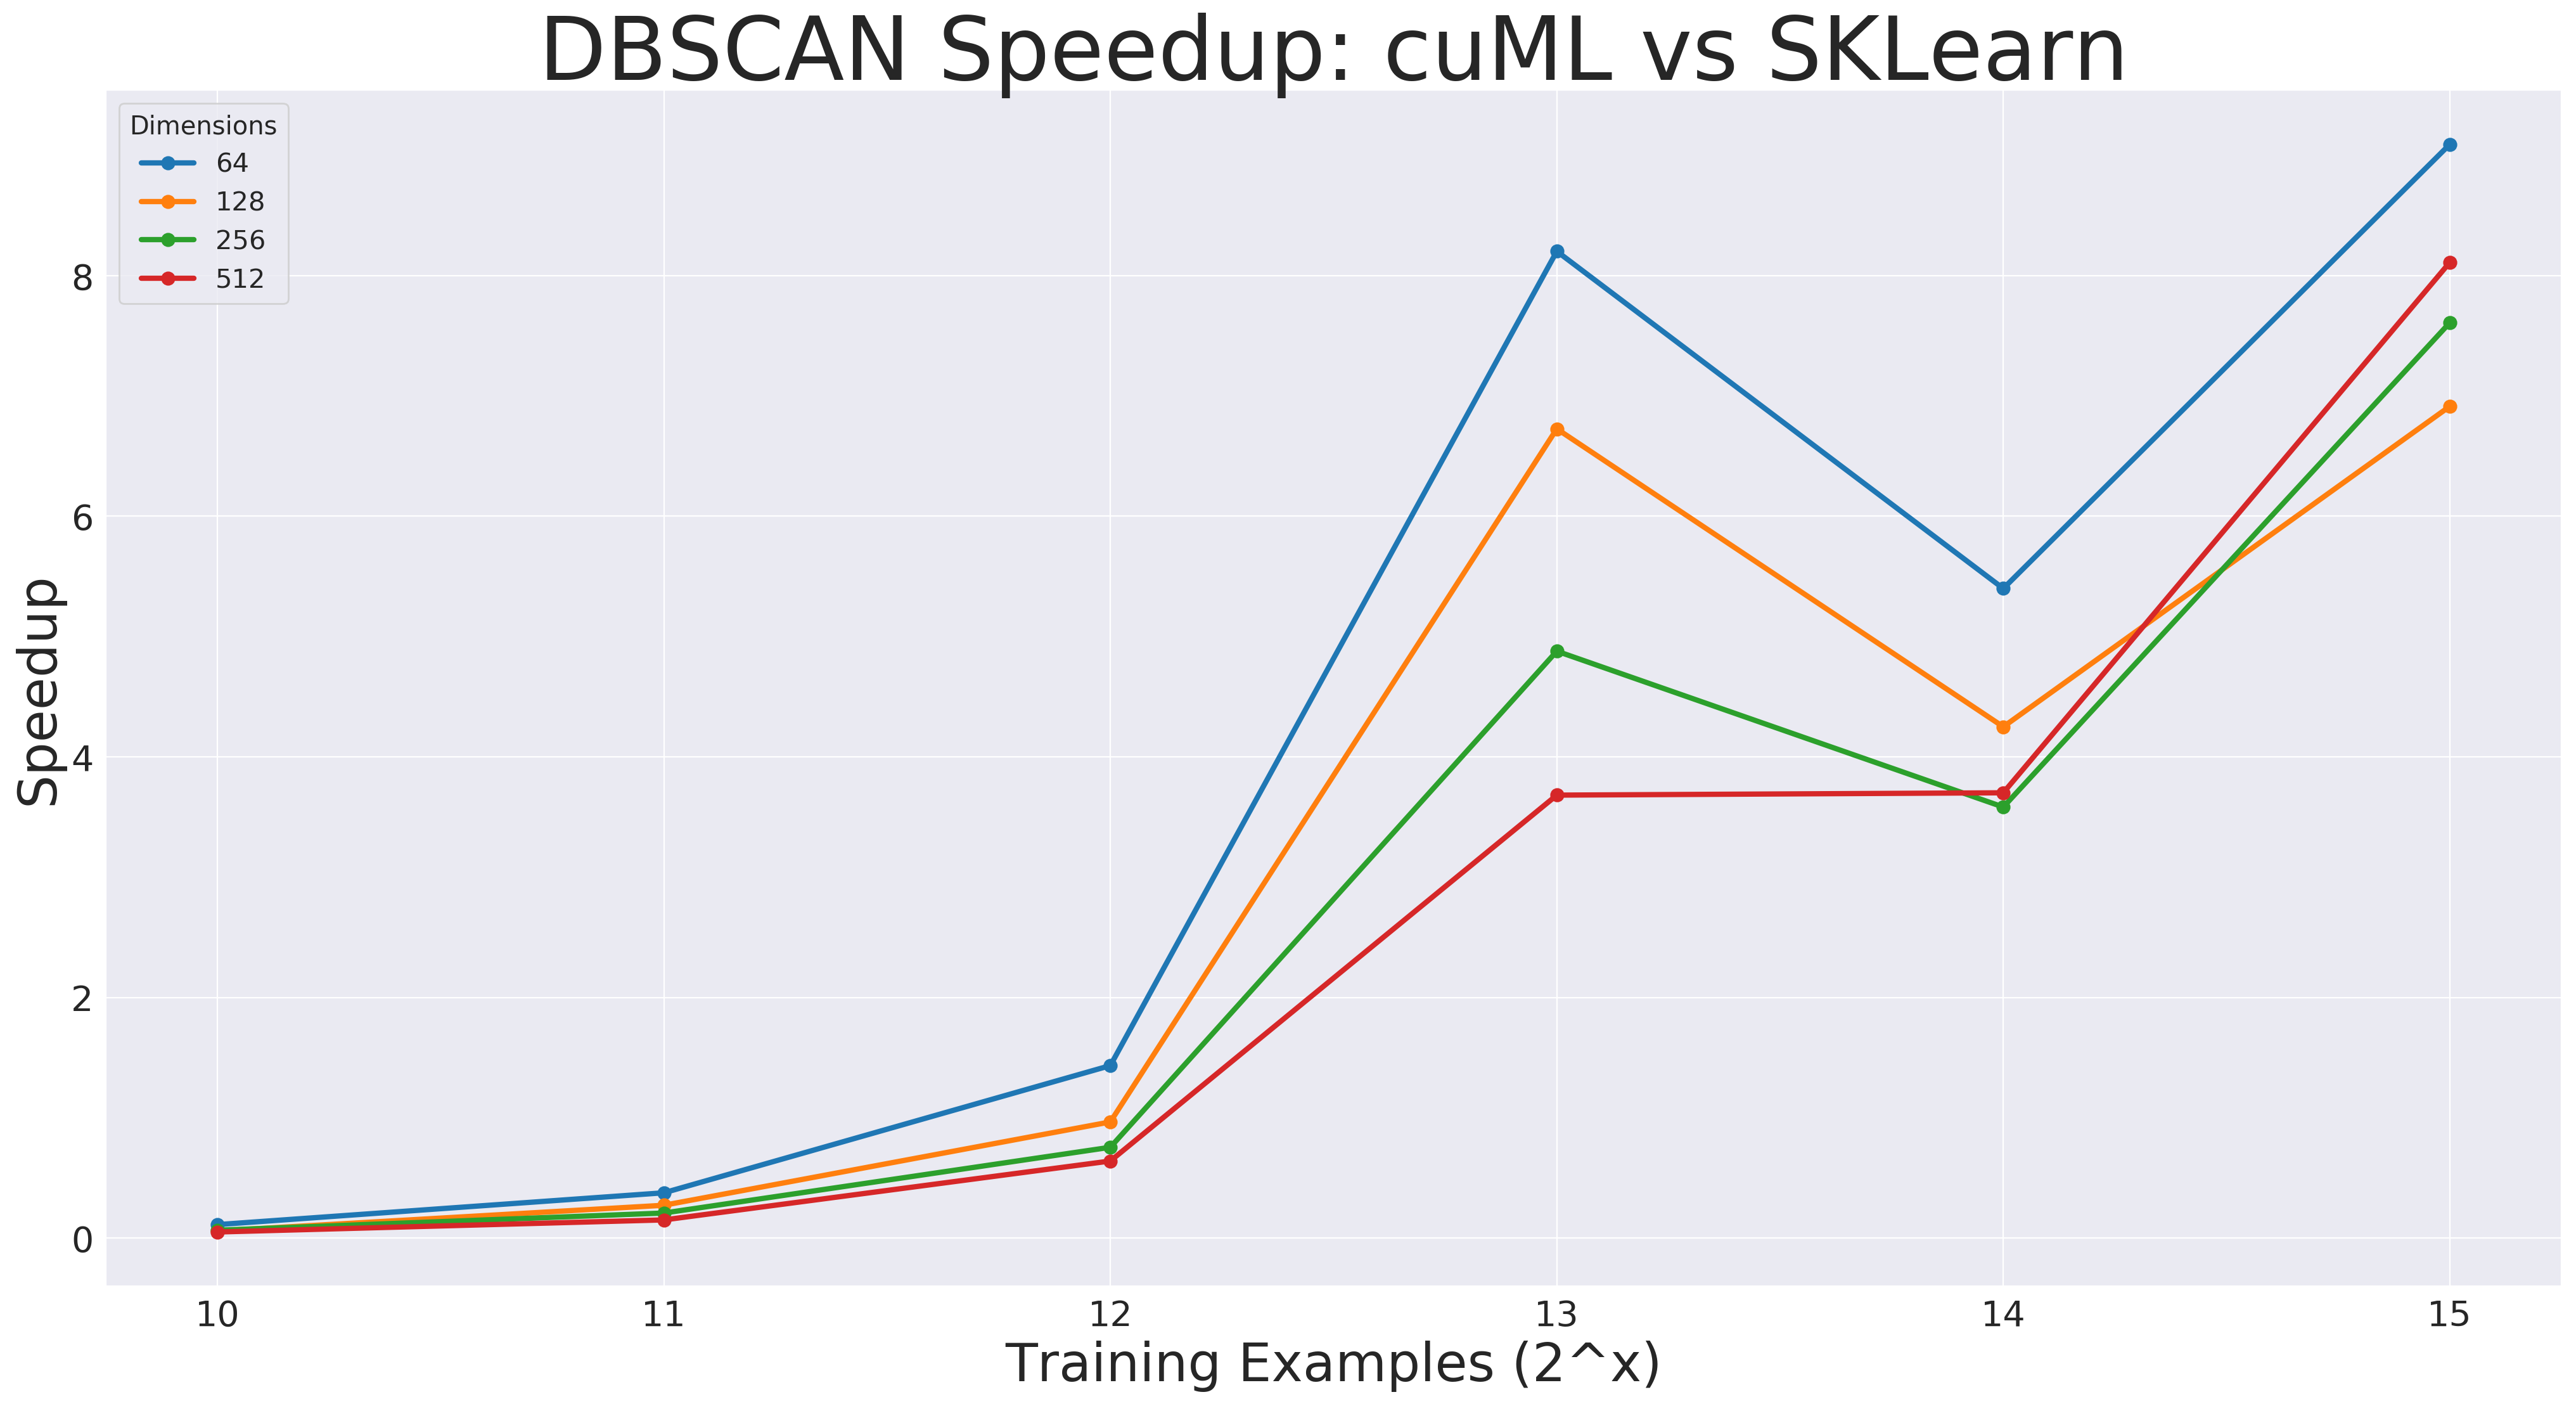

In [35]:
chart_results(final_results["dbscan"], title = "DBSCAN Speedup: cuML vs SKLearn")